In [1]:
!pip install nibabel -q
!pip install scikit-learn -q
!pip install tqdm -q
!pip install split-folders -q
!pip install torchinfo -q
!pip install segmentation-models-pytorch-3d -q
!pip install livelossplot -q
!pip install torchmetrics -q
!pip install tensorboard -q

In [2]:
import os
import random
import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time
 
from dataclasses import dataclass
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.cuda import amp
 
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy
 
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import gc
 
import segmentation_models_pytorch_3d as smp
 
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

In [3]:
def seed_everything(SEED):
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False
 
 
def get_default_device():
   gpu_available = torch.cuda.is_available()
   return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

In [4]:
@dataclass(frozen=True)
class TrainingConfig:
   BATCH_SIZE:      int = 3
   EPOCHS:          int = 100
   LEARNING_RATE: float = 1e-3
   CHECKPOINT_DIR:  str = os.path.join('model_checkpoint', '3D_UNet_Brats2023')
   NUM_WORKERS:     int = 4

In [5]:
scaler = MinMaxScaler()
 
DATASET_PATH = "/kaggle/input/brats2023-part-1"
DATASET_PATH_2="/kaggle/input/brats2023-part-2zip"

print("Total Files: ", len(os.listdir(DATASET_PATH)))
print("Total Files: ", len(os.listdir(DATASET_PATH_2)))

Total Files:  625
Total Files:  626


In [6]:
t1ce_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t1c.nii"))
t2_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t2w.nii"))
flair_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t2f.nii"))
mask_list = sorted(glob.glob(f"{DATASET_PATH}/*/*seg.nii"))
 
print("t1ce list: ", len(t1ce_list))
print("t2 list: ", len(t2_list))
print("flair list: ", len(flair_list))
print("Mask list: ", len(mask_list))

t1ce list:  625
t2 list:  625
flair list:  625
Mask list:  625


In [7]:
!rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [8]:
scaler = MinMaxScaler()

# Create the necessary directories
os.makedirs("BraTS2023_Preprocessed/input_data_3channels/images", exist_ok=True)
os.makedirs("BraTS2023_Preprocessed/input_data_3channels/masks", exist_ok=True)
os.makedirs("BraTS2023_Preprocessed/input_data_3channels/train/images", exist_ok=True)
os.makedirs("BraTS2023_Preprocessed/input_data_3channels/train/masks", exist_ok=True)
os.makedirs("BraTS2023_Preprocessed/input_data_3channels/test/images", exist_ok=True)
os.makedirs("BraTS2023_Preprocessed/input_data_3channels/test/masks", exist_ok=True)

# Prepare and save the data
image_filenames = []
mask_filenames = []

for idx in tqdm(range(55), desc="Preparing to stack, crop and save", unit="file"):
    # Load and preprocess images
    t1ce_image = nib.load(t1ce_list[idx]).get_fdata()
    t1ce_image = scaler.fit_transform(t1ce_image.reshape(-1, t1ce_image.shape[-1])).reshape(t1ce_image.shape)

    t2_image = nib.load(t2_list[idx]).get_fdata()
    t2_image = scaler.fit_transform(t2_image.reshape(-1, t2_image.shape[-1])).reshape(t2_image.shape)

    flair_image = nib.load(flair_list[idx]).get_fdata()
    flair_image = scaler.fit_transform(flair_image.reshape(-1, flair_image.shape[-1])).reshape(flair_image.shape)

    mask = nib.load(mask_list[idx]).get_fdata()

    # Stack images and crop
    combined_images = np.stack([flair_image, t1ce_image, t2_image], axis=3)
    combined_images = combined_images[40:200,39:199, 14:142]
    mask = mask[40:200,39:199,14:142]

    # Check mask coverage
    if (1 - (np.unique(mask, return_counts=True)[1][0] / mask.size)) > 0.01:
        mask = F.one_hot(torch.tensor(mask, dtype=torch.long), num_classes=4)

        # Save images and masks
        image_filename = f"BraTS2023_Preprocessed/input_data_3channels/images/image_{idx}.npy"
        mask_filename = f"BraTS2023_Preprocessed/input_data_3channels/masks/mask_{idx}.npy"
        np.save(image_filename, combined_images)
        np.save(mask_filename, mask)
        image_filenames.append(image_filename)
        mask_filenames.append(mask_filename)
# Split the data into train and test sets
train_image_filenames, test_image_filenames, train_mask_filenames, test_mask_filenames = train_test_split(
    image_filenames, mask_filenames, test_size=0.25, random_state=42
)

# Save the train and test sets
for filename in train_image_filenames:
    os.makedirs(os.path.dirname(filename.replace("images", "train/images")), exist_ok=True)
    os.rename(filename, filename.replace("images", "train/images"))

for filename in test_image_filenames:
    os.makedirs(os.path.dirname(filename.replace("images", "test/images")), exist_ok=True)
    os.rename(filename, filename.replace("images", "test/images"))

for filename in train_mask_filenames:
    os.makedirs(os.path.dirname(filename.replace("masks", "train/masks")), exist_ok=True)
    os.rename(filename, filename.replace("masks", "train/masks"))

for filename in test_mask_filenames:
    os.makedirs(os.path.dirname(filename.replace("masks", "test/masks")), exist_ok=True)
    os.rename(filename, filename.replace("masks", "test/masks"))

Preparing to stack, crop and save: 100%|██████████| 10/10 [00:18<00:00,  1.88s/file]


In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, normalization=True):
        super().__init__()
        
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_list = sorted(os.listdir(img_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.normalization = normalization

    def load_file(self, filepath):
        # Load file from path (assuming .npy format)
        return np.load(filepath)
    
    def __len__(self):
        # Return the number of image files
        return len(self.img_list)
    
    def zscore_normalize(self, image):
        # Z-score normalization
        mean, std = image.mean(), image.std()
        if std > 0:
            image = (image - mean) / std
        else:
            image = image - mean  # No standard deviation
        return image
    
    def __getitem__(self, idx):
        # Load image and mask
        image = self.load_file(os.path.join(self.img_dir, self.img_list[idx]))
        mask = self.load_file(os.path.join(self.mask_dir, self.mask_list[idx]))

        # Apply z-score normalization if enabled
        if self.normalization:
            image = self.zscore_normalize(image)

        # Ensure images and masks are in C, D, H, W format (channels first)
        # Assuming the shape is [D, H, W, C] (Depth, Height, Width, Channels)
        image = torch.from_numpy(image).permute(3, 2, 0, 1)  # C, D, H, W
        mask = torch.from_numpy(mask).permute(3, 2, 0, 1)  # C, D, H, W
        
        return image, mask


In [6]:
train_img_dir = "BraTS2023_Preprocessed/input_data_3channels/train/images"
train_mask_dir = "BraTS2023_Preprocessed/input_data_3channels/train/masks"
 
val_img_dir = "BraTS2023_Preprocessed/input_data_3channels/test/images"
val_mask_dir = "BraTS2023_Preprocessed/input_data_3channels/test/masks"
 
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
 
# Initialize datasets with normalization only
train_dataset = BraTSDataset(train_img_dir, train_mask_dir, normalization=True)
val_dataset = BraTSDataset(val_img_dir, val_mask_dir, normalization=True)
 
# Print dataset statistics
print("Total Training Samples: ", len(train_dataset))
print("Total Val Samples: ", len(val_dataset))


Total Training Samples:  33
Total Val Samples:  12


In [7]:
train_loader = DataLoader(train_dataset, batch_size = 3, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 3, shuffle = False, num_workers = 4)
                     
#Sanity Check               
images, masks = next(iter(train_loader))
print(f"Train Image batch shape: {images.shape}")
print(f"Train Mask batch shape: {masks.shape}")


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Image batch shape: torch.Size([3, 3, 128, 160, 160])
Train Mask batch shape: torch.Size([3, 4, 128, 160, 160])


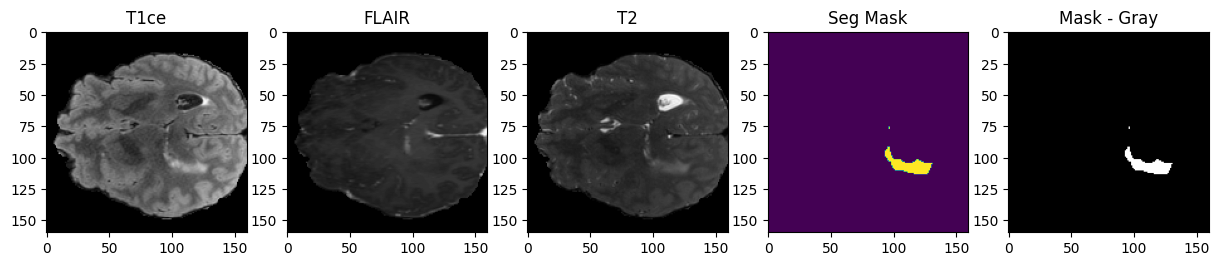

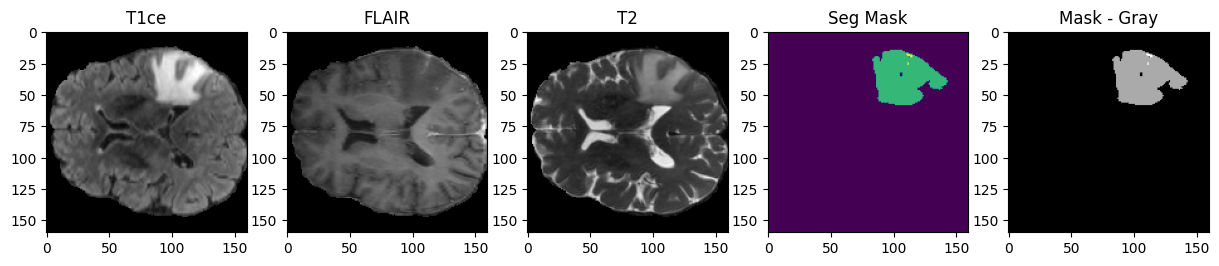

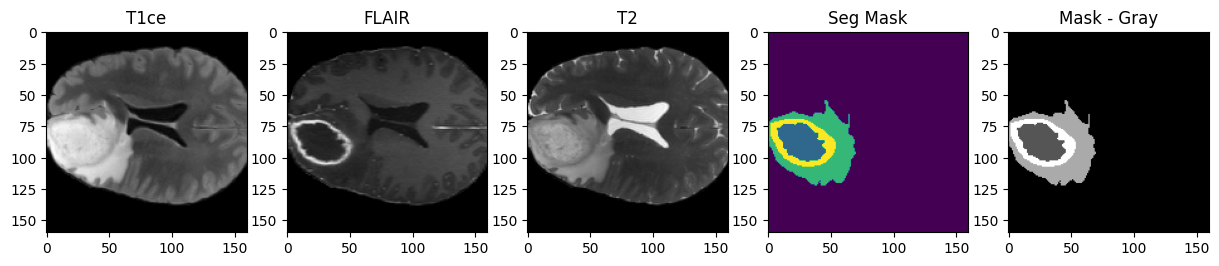

In [12]:
# def visualize_slices(images, masks, num_slices=20):
#    batch_size = images.shape[0]
   
#    masks = torch.argmax(masks, dim=1) #along the channel/class dim
   
#    for i in range(min(num_slices, batch_size)):
#        fig,ax = plt.subplots(1,5,figsize = (15,5))
       
#        middle_slice = images.shape[2] // 2
#        ax[0].imshow(images[i,0, middle_slice,:,:], cmap = 'gray')
#        ax[1].imshow(images[i, 1, middle_slice, : ,:], cmap = 'gray')
#        ax[2].imshow(images[i, 2, middle_slice, :, :], cmap = 'gray')
#        ax[3].imshow(masks[i, middle_slice, : ,:], cmap = 'viridis')
#        ax[4].imshow(masks[i, middle_slice, : ,:], cmap = 'gray')
       
#        ax[0].set_title('T1ce')
#        ax[1].set_title('FLAIR')
#        ax[2].set_title('T2')
#        ax[3].set_title('Seg Mask')
#        ax[4].set_title('Mask - Gray')
       
#        plt.show()
 
# visualize_slices(images, masks, num_slices = 20)

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Define the double_conv function
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Contraction path
        self.conv1 = double_conv(in_channels=in_channels, out_channels=16)
        self.pool1 = nn.MaxPool3d(kernel_size=2)

        self.conv2 = double_conv(in_channels=16, out_channels=32)
        self.pool2 = nn.MaxPool3d(kernel_size=2)

        self.conv3 = double_conv(in_channels=32, out_channels=64)
        self.pool3 = nn.MaxPool3d(kernel_size=2)

        self.conv4 = double_conv(in_channels=64, out_channels=128)
        self.pool4 = nn.MaxPool3d(kernel_size=2)
        
        self.conv5 = double_conv(in_channels=128, out_channels=256)

        # Expansive path
        self.upconv6 = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv6 = double_conv(in_channels=256, out_channels=128)

        self.upconv7 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv7 = double_conv(in_channels=128, out_channels=64)

        self.upconv8 = nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.conv8 = double_conv(in_channels=64, out_channels=32)

        self.upconv9 = nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.conv9 = double_conv(in_channels=32, out_channels=16)

        self.out_conv = nn.Conv3d(in_channels=16, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)  # downscale

        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)  # upscale
        u6 = torch.cat([u6, c4], dim=1)  # skip connections along channel dim
        c6 = self.conv6(u6)

        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)

        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)

        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        outputs = self.out_conv(c9)

        return outputs


# Test the model
model = UNet3D(in_channels=3, out_channels=4)
print(model)

# # Create a random input tensor with the new specified dimensions
# ip_tensor = torch.randn(3, 3, 160, 160, 128)  # Batch size 3, 3 channels, dimensions 160x160x128

# # Forward pass through the model
# output = model(ip_tensor)

# # Print input and output shapes
# print("-" * 260)
# print(f"Input shape: {ip_tensor.shape}")
# print(f"Output shape: {output.shape}")


UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [9]:
focal_loss = smp.losses.FocalLoss(mode="multiclass", alpha=0.25, gamma=2.0)
dice_loss = smp.losses.DiceLoss(mode="multiclass", classes=None, log_loss=False, from_logits=True, smooth=1e-5, ignore_index=None, eps=1e-7)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EdgeRecallLoss3D(nn.Module):
    def __init__(self, epsilon=1e-6, device='cpu'):
        super(EdgeRecallLoss3D, self).__init__()
        self.epsilon = epsilon
        
        # Create 3D Laplacian kernel (26-connectivity)
        kernel = torch.ones(3, 3, 3) * -1
        kernel[1, 1, 1] = 26  # Center point
        self.laplacian = kernel.unsqueeze(0).unsqueeze(0)  # [1,1,3,3,3]
        # Repeat for each class channel (4 classes)
        self.laplacian = self.laplacian.repeat(4, 1, 1, 1, 1).to(device)  # [4,1,3,3,3]

    def edge_retrieve(self, target):
        # Apply 3D convolution to detect edges
        edge = F.conv3d(target, self.laplacian, groups=4, padding=1)
        
        # Zero out boundaries to avoid edge artifacts
        edge[:, :, 0, :, :] = 0  # First depth slice
        edge[:, :, -1, :, :] = 0  # Last depth slice
        edge[:, :, :, 0, :] = 0  # First row
        edge[:, :, :, -1, :] = 0  # Last row
        edge[:, :, :, :, 0] = 0  # First column
        edge[:, :, :, :, -1] = 0  # Last column
        
        # Binarize edges
        edge = (edge != 0).float()
        edge = torch.multiply(target, edge)
        
        return edge

    def get_tp_fp_fn(self, pred, gt_edge):
        # Ensure predictions are in [0,1] range
        pred = torch.sigmoid(pred)
        
        tp = pred * gt_edge
        fp = pred * (1 - gt_edge)
        fn = (1 - pred) * gt_edge
        
        tp = tp.sum()
        fp = fp.sum()
        fn = fn.sum()
        return tp, fp, fn

    def forward(self, pred, target):
        gt_edge = self.edge_retrieve(target)
        tp, fp, fn = self.get_tp_fp_fn(pred, gt_edge)
        recall = (tp + self.epsilon) / (tp + fn + self.epsilon)
        # Ensure loss is positive
        return torch.abs(1 - recall)

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2, reduction='mean', device='cpu'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
#         self.device = device

#     def forward(self, pred, target):
#         # Ensure predictions are probabilities
#         pred = torch.sigmoid(pred)
        
#         # Calculate BCE loss
#         bce_loss = F.binary_cross_entropy(pred, target, reduction='none')
        
#         # Calculate focal term
#         pt = target * pred + (1 - target) * (1 - pred)
#         focal_term = (1 - pt) ** self.gamma
        
#         # Calculate final focal loss
#         focal_loss = self.alpha * focal_term * bce_loss
        
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         return focal_loss

# class DiceLoss(nn.Module):
#     def __init__(self, epsilon=1e-6, device='cpu'):
#         super(DiceLoss, self).__init__()
#         self.epsilon = epsilon

#     def forward(self, pred, target):
#         # Ensure predictions are probabilities
#         pred = torch.sigmoid(pred)
        
#         # Calculate Dice coefficient
#         intersection = (pred * target).sum()
#         union = pred.sum() + target.sum()
        
#         dice = (2. * intersection + self.epsilon) / (union + self.epsilon)
#         return 1. - dice  # Convert to loss (always positive)

class HybridEdgeFocalLoss3D(nn.Module):
    def __init__(self, alpha=0.25, reduction='mean', device='cpu', weight=0.5):
        super(HybridEdgeFocalLoss3D, self).__init__()
        self.reduction = reduction
        self.weight = weight
        self.focal_loss = FocalLoss(alpha=alpha, reduction="none", device=device)
        self.edge_loss = EdgeRecallLoss3D(device=device)

    def forward(self, pred, target):
        # Calculate component losses
        floss = focal_loss(pred, target)
        eloss = self.edge_loss(pred, target)
        
        # Combine losses
        final_loss =  floss +  eloss
        
        # Ensure loss is positive
        final_loss = torch.abs(final_loss)
        
        if self.reduction == 'mean':
            return final_loss.mean()
        elif self.reduction == 'sum':
            return final_loss.sum()
        return final_loss

class EDFLoss3D(nn.Module):
    def __init__(self, alpha=0.25, reduction='mean', device='cpu', theta=0.4, beta=0.3, gamma=0.3):
        super(EDFLoss3D, self).__init__()
        self.reduction = reduction
        self.theta = theta
        self.beta = beta
        self.gamma = gamma
        self.focal_loss = FocalLoss(alpha=alpha, reduction="none", device=device)
        self.edge_loss = EdgeRecallLoss3D(device=device)
        self.dice_loss = DiceLoss(device=device)

    def forward(self, pred, target):
        # Calculate component losses
        floss = focal_loss(pred, target)
        eloss = self.edge_loss(pred, target)
        dloss = dice_loss(pred, target)
        
        # Combine losses with weights
        final_loss = floss + eloss + dloss
        
        # Ensure loss is positive
        final_loss = torch.abs(final_loss)
        
        if self.reduction == 'mean':
            return final_loss.mean()
        elif self.reduction == 'sum':
            return final_loss.sum()
        return final_loss

In [11]:
def create_checkpoint_dir(checkpoint_dir):
   if not os.path.exists(checkpoint_dir):
       os.makedirs(checkpoint_dir)
   try:
       num_versions = [int(i.split("_")[-1]) for i in os.listdir(checkpoint_dir) if "version" in i]
       version_num = max(num_versions) + 1
   except:
       version_num = 0

   version_dir = os.path.join(checkpoint_dir, "version_" + str(version_num))
   os.makedirs(version_dir)

   print(f"Checkpoint directory: {version_dir}")
   return version_dir

In [12]:
# combined_loss = EdgeFocalLoss(edge_weight=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = HybridEdgeFocalLoss3D(
    alpha=0.25,
    device=device,
    weight=0.5  # Balance between focal and edge loss
)

In [13]:

def train_one_epoch(
    model,
    loader,
    optimizer,
    criterion,  # HybridEdgeFocalLoss3D instance
    num_classes,
    device="cpu",
    epoch_idx=800,
    total_epochs=50
):
    model.train()
    loss_record = MeanMetric()
    metric_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')
    loader_len = len(loader)
    
    with tqdm(total=loader_len, ncols=122) as tq:
        tq.set_description(f"Train ::  Epoch: {epoch_idx}/{total_epochs}")
        for data, target in loader:
            tq.update(1)
            data, target = data.to(device).float(), target.to(device).float()
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)  # [B, C, D, H, W]
            
            # Convert output to probabilities
            output_probs = torch.sigmoid(output)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Evaluation metrics
            with torch.no_grad():
                # Convert probabilities to class predictions
                pred_idx = output_probs.argmax(dim=1)
                target_idx = target.argmax(dim=1)
                
                # Calculate IoU metrics
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_idx, 
                    target_idx, 
                    mode='multiclass', 
                    num_classes=num_classes
                )
                
                # Calculate macro IoU
                metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
                
                # Update metrics
                acc_record.update(pred_idx.cpu(), target_idx.cpu())
                loss_record.update(loss.detach().cpu(), weight=data.shape[0])
                metric_record.update(metric_macro.cpu(), weight=data.shape[0])
                
            # Update progress bar
            tq.set_postfix_str(
                s=f"Loss: {loss_record.compute():.4f}, "
                f"IOU: {metric_record.compute():.4f}, "
                f"Acc: {acc_record.compute():.4f}"
            )
    
    epoch_loss = loss_record.compute()
    epoch_metric = metric_record.compute()
    epoch_acc = acc_record.compute()
    
    return epoch_loss, epoch_metric, epoch_acc

In [14]:
def validate(
    model,
    loader,
    criterion,  # HybridEdgeFocalLoss3D instance
    device,
    num_classes,
    epoch_idx,
    total_epochs
):
    model.eval()
    loss_record = MeanMetric()
    metric_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')
    loader_len = len(loader)
    
    with tqdm(total=loader_len, ncols=122) as tq:
        tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")
        for data, target in loader:
            tq.update(1)
            data, target = data.to(device).float(), target.to(device).float()
            
            with torch.no_grad():
                # Forward pass
                output = model(data)
                # Convert to probabilities
                output_probs = torch.sigmoid(output)
                # Calculate loss
                loss = criterion(output, target)
                
                # Convert to class predictions
                pred_idx = output_probs.argmax(dim=1)
                target_idx = target.argmax(dim=1)
                
                # Calculate IoU metrics
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_idx, 
                    target_idx, 
                    mode='multiclass', 
                    num_classes=num_classes
                )
                
                # Calculate macro IoU
                metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
                
                # Update metrics
                acc_record.update(pred_idx.cpu(), target_idx.cpu())
                loss_record.update(loss.cpu(), weight=data.shape[0])
                metric_record.update(metric_macro.cpu(), weight=data.shape[0])
                
            # Update progress bar
            tq.set_postfix_str(
                s=f"Loss: {loss_record.compute():.4f}, "
                f"IOU: {metric_record.compute():.4f}, "
                f"Acc: {acc_record.compute():.4f}"
            )
    
    valid_epoch_loss = loss_record.compute()
    valid_epoch_metric = metric_record.compute()
    valid_epoch_acc = acc_record.compute()
    
    return valid_epoch_loss, valid_epoch_metric, valid_epoch_acc

In [15]:
def main(
    *, 
    model, 
    optimizer, 
    ckpt_dir, 
    pin_memory=True, 
    device='cpu',
    num_classes=4,
    total_epochs=TrainingConfig.EPOCHS
):
    # Initialize the hybrid loss function
    criterion = HybridEdgeFocalLoss3D(
        alpha=0.25,
        device=device,
        weight=0.5  # Balance between focal and edge loss
    ).to(device)
    
    # Move model to the correct device before the loop starts
    model.to(device, non_blocking=True)
    
    # Initialize tensorboard writer
    writer = SummaryWriter(log_dir=os.path.join(ckpt_dir, 'tboard_logs'))
    
    # Initialize tracking variables
    best_loss = float("inf")
    live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(8, 3)), ExtremaPrinter()])
    
    for epoch in range(total_epochs):
        current_epoch = epoch + 1
        
        # Clear GPU memory
        torch.cuda.empty_cache()
        gc.collect()
        
        # Train one epoch
        train_loss, train_metric, train_acc = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,  # Pass the criterion
            num_classes=num_classes,
            device=device,
            epoch_idx=current_epoch,
            total_epochs=total_epochs
        )
        
        # Validate after each epoch
        valid_loss, valid_metric, valid_acc = validate(
            model=model,
            loader=val_loader,
            criterion=criterion,  # Pass the criterion
            device=device,
            num_classes=num_classes,
            epoch_idx=current_epoch,
            total_epochs=total_epochs
        )
        
        # Update live plot
        live_plot.update({
            "loss": train_loss,
            "val_loss": valid_loss,
            "accuracy": train_acc,
            "val_accuracy": valid_acc,
            "IoU": train_metric,
            "val_IoU": valid_metric
        })
        live_plot.send()
        
        # Write training and validation metrics to TensorBoard
        writer.add_scalar('Loss/train', train_loss, current_epoch)
        writer.add_scalar('Loss/valid', valid_loss, current_epoch)
        writer.add_scalar('Accuracy/train', train_acc, current_epoch)
        writer.add_scalar('Accuracy/valid', valid_acc, current_epoch)
        writer.add_scalar('IoU/train', train_metric, current_epoch)
        writer.add_scalar('IoU/valid', valid_metric, current_epoch)
        
        
        # Save the model if validation loss improves
        if valid_loss < best_loss:
            best_loss = valid_loss
            print("Model Improved. Saving...", end="")
            checkpoint_dict = {
                "opt": optimizer.state_dict(),
                "model": model.state_dict(),
                "criterion": criterion.state_dict(),  # Save loss function state
                "epoch": current_epoch,
                "best_loss": best_loss
            }
            torch.save(checkpoint_dict, os.path.join(ckpt_dir, "ckpt.tar"))
            del checkpoint_dict
            print("Done.\n")
    
    writer.close()
    return

In [16]:
seed_everything(SEED = 42)

DEVICE, GPU_AVAILABLE  = get_default_device()
print(DEVICE)

CKPT_DIR = create_checkpoint_dir(TrainingConfig.CHECKPOINT_DIR)

from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,  
    weight_decay=1e-2,                # Regularization to avoid overfitting
    amsgrad=True                      # Optional AMSGrad variant
)
scheduler = CosineAnnealingLR(optimizer, T_max=TrainingConfig.EPOCHS)


cuda
Checkpoint directory: model_checkpoint/3D_UNet_Brats2023/version_2


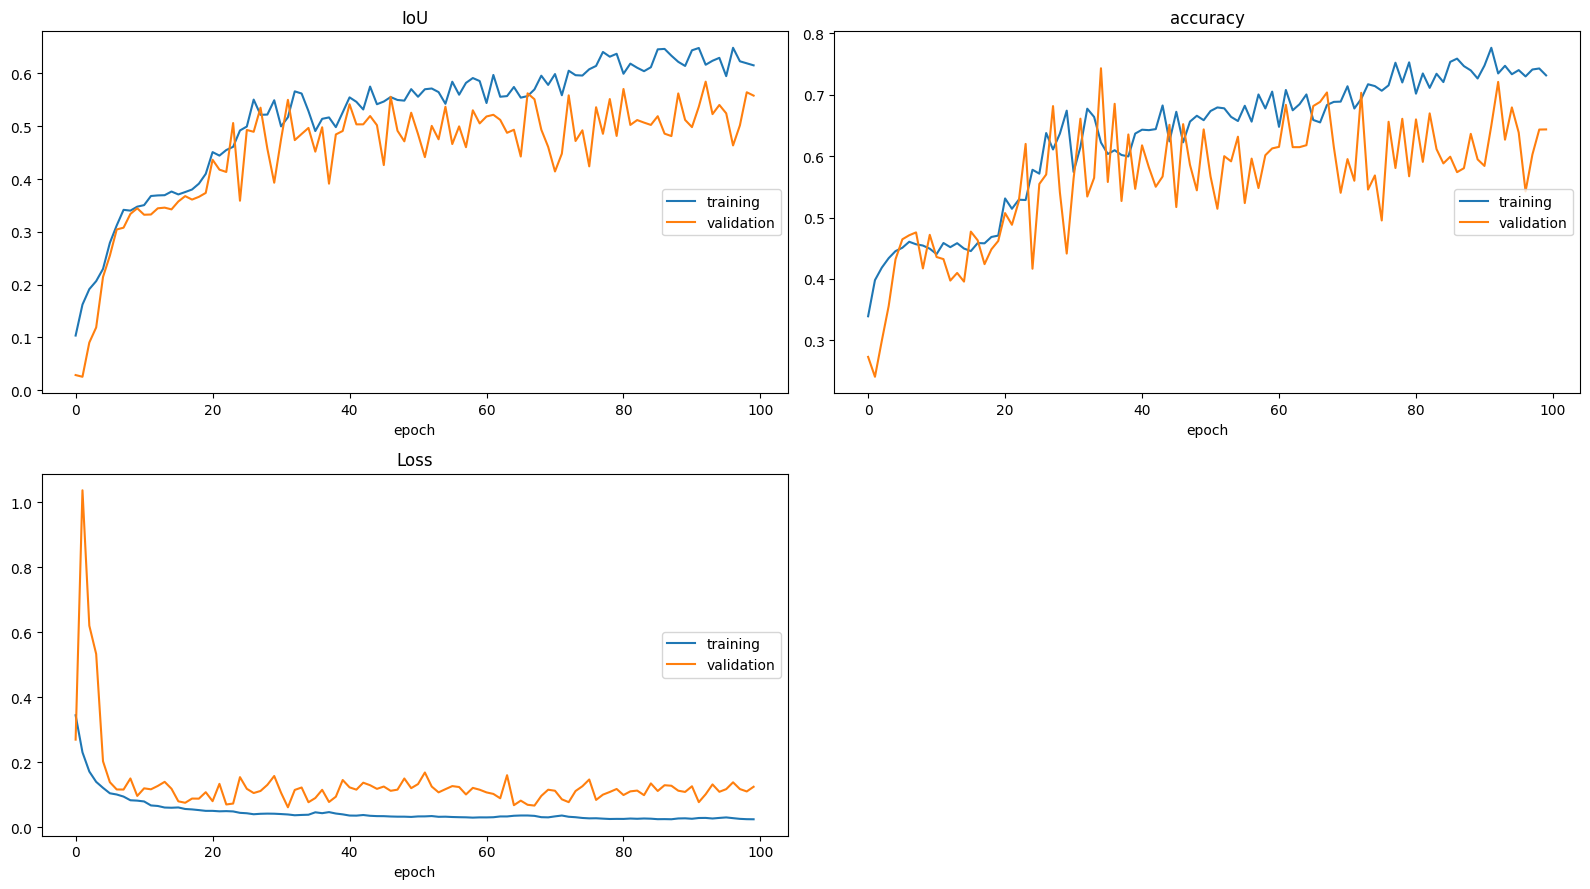

IoU
	training         	 (min:    0.104, max:    0.649, cur:    0.615)
	validation       	 (min:    0.026, max:    0.584, cur:    0.558)
accuracy
	training         	 (min:    0.339, max:    0.777, cur:    0.732)
	validation       	 (min:    0.241, max:    0.743, cur:    0.644)
Loss
	training         	 (min:    0.024, max:    0.345, cur:    0.024)
	validation       	 (min:    0.061, max:    1.037, cur:    0.124)


In [17]:
main(
    model = model,
    optimizer = optimizer,
    ckpt_dir = CKPT_DIR,
    device  = DEVICE,
    pin_memory = GPU_AVAILABLE
)

In [18]:
DEVICE, GPU_AVAILABLE = get_default_device()

trained_model = UNet3D(in_channels = 3, out_channels = 4)

trained_model.load_state_dict(torch.load("model_checkpoint/3D_UNet_Brats2023/version_0/ckpt.tar", map_location = "cpu")['model'])

trained_model.to(DEVICE)
trained_model.eval()

/tmp/ipykernel_30/2735865689.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("model_checkpoint/3D_UNet_Brats2023/version_0/ckpt.

UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

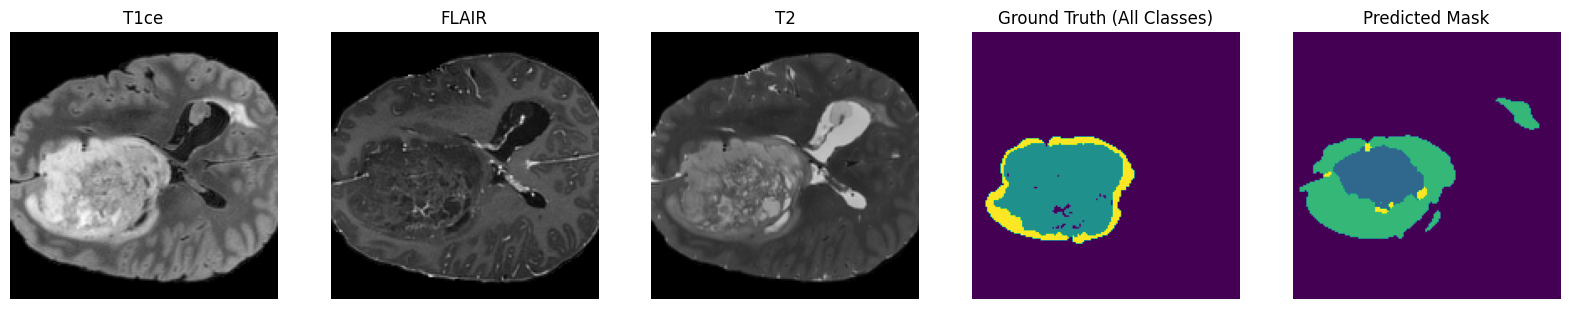

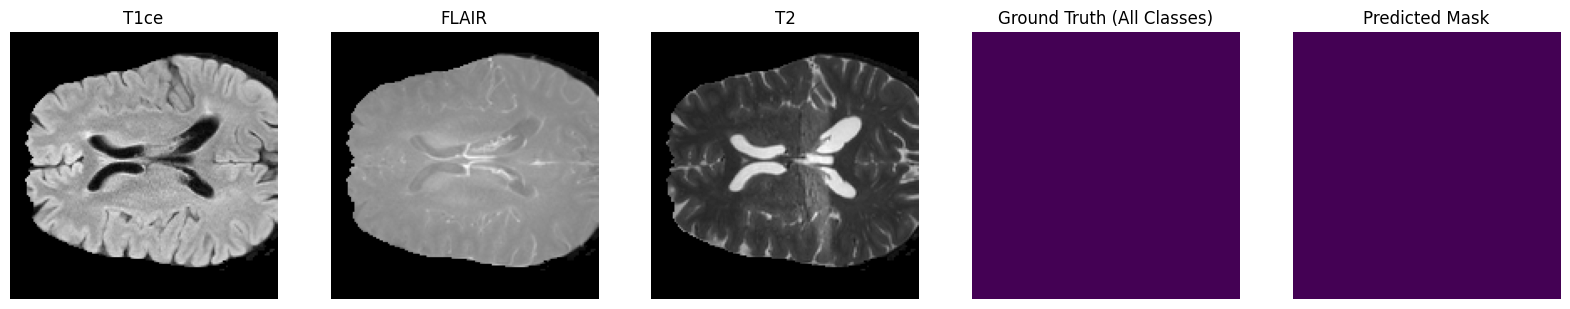

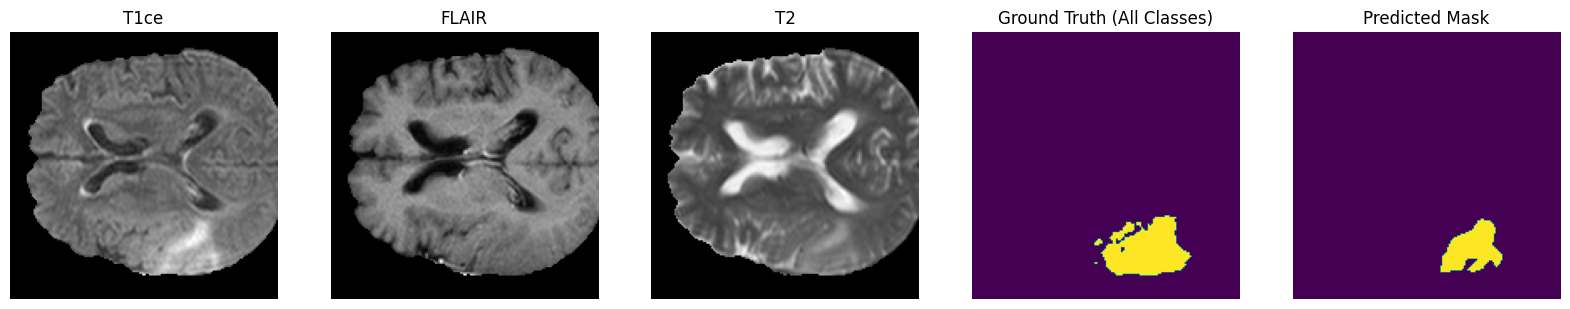

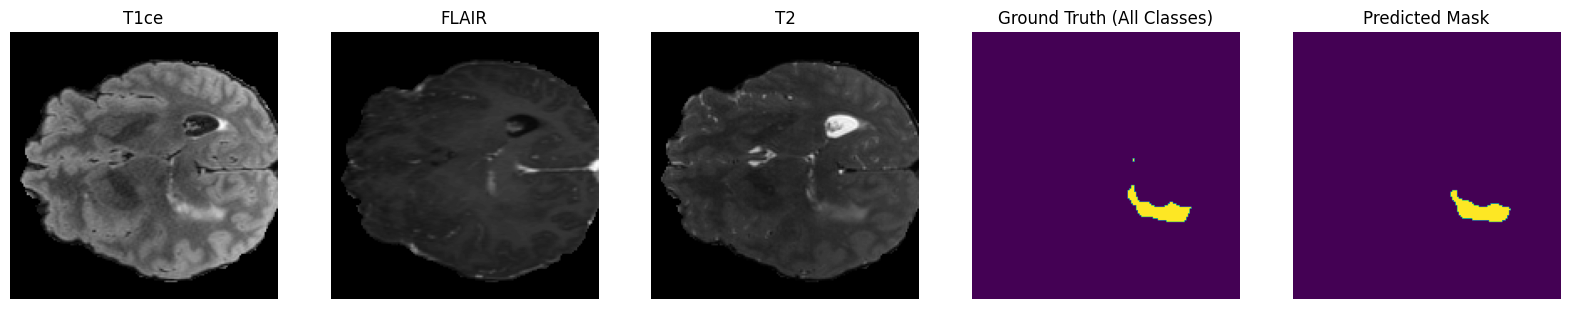

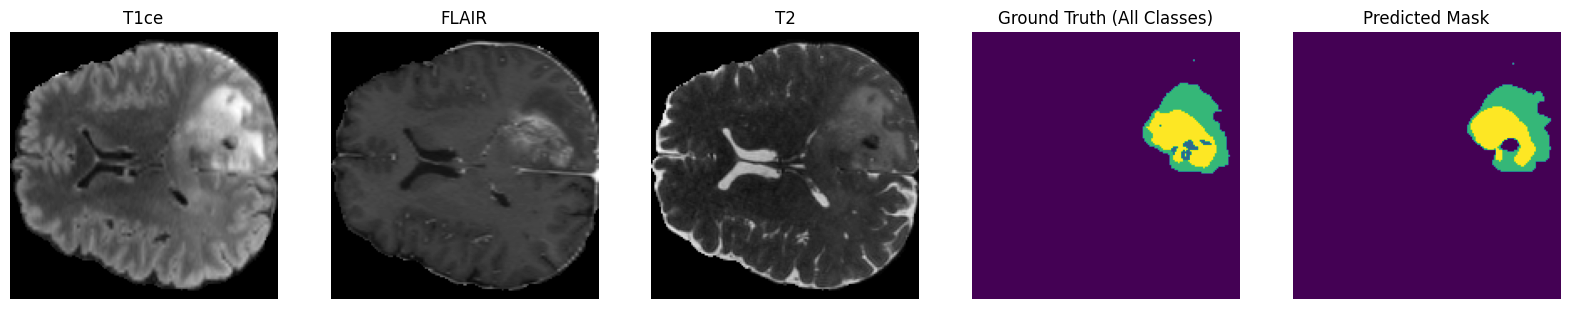

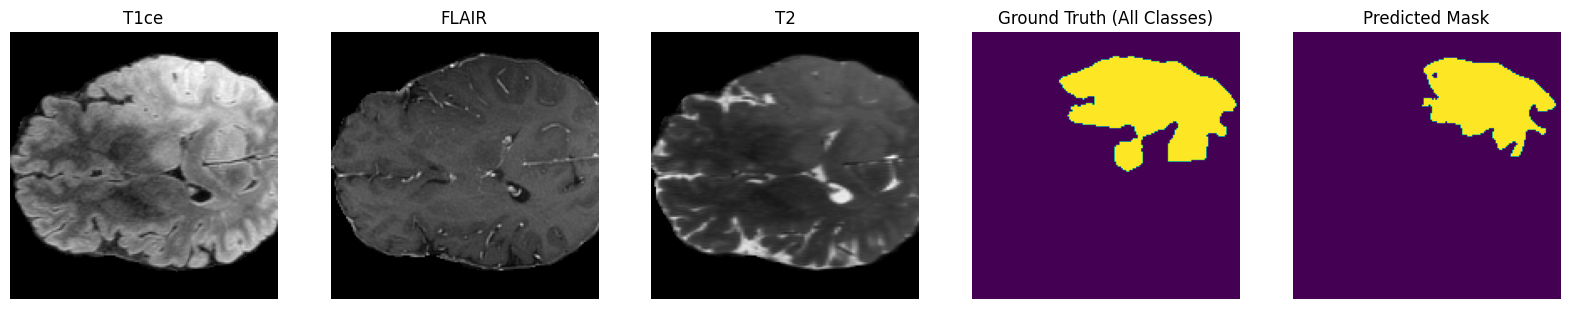

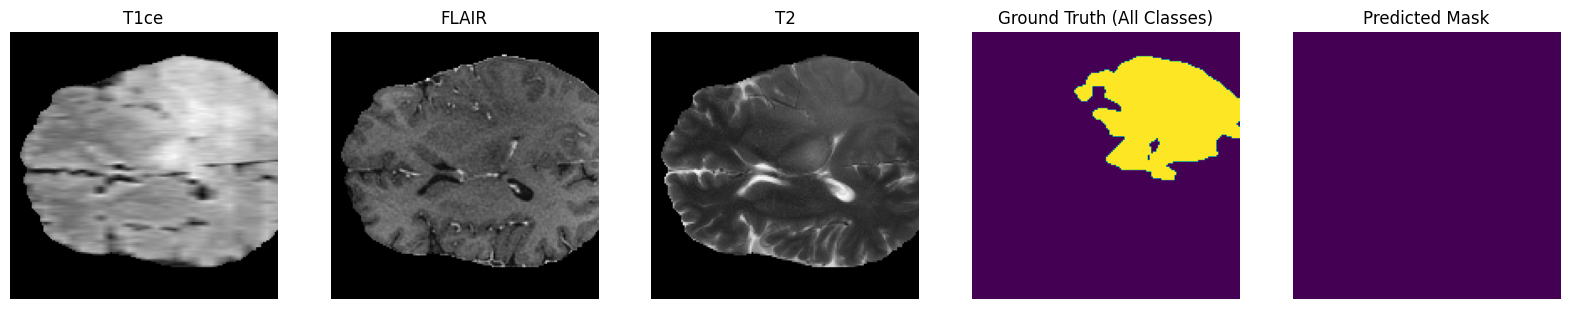

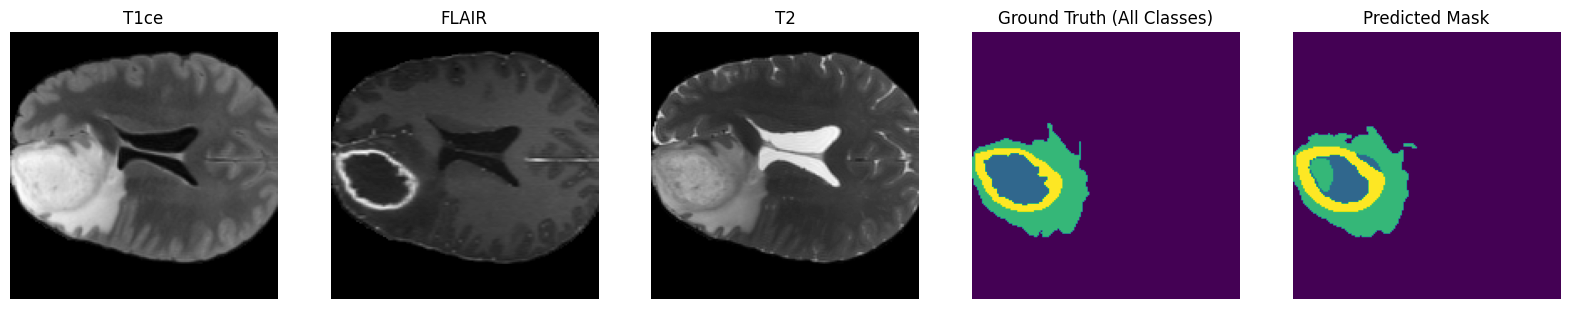

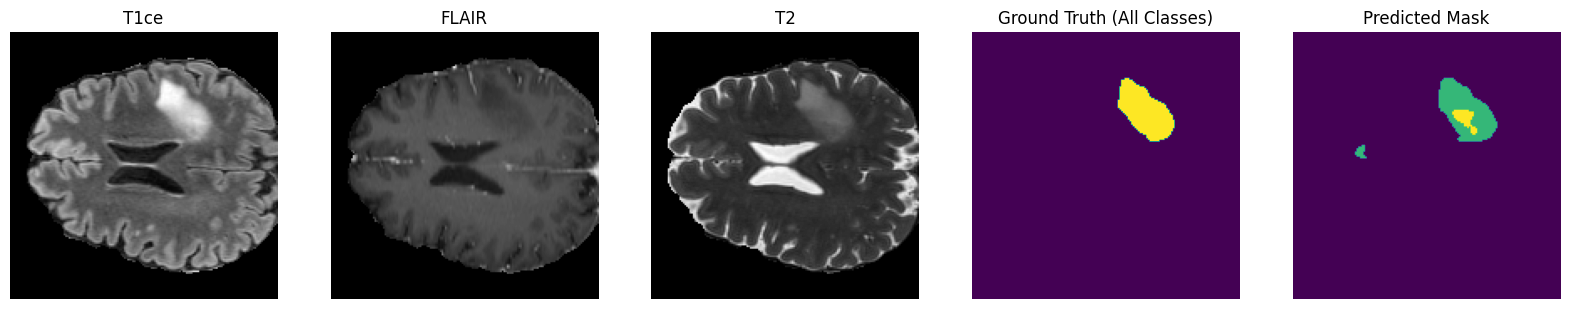

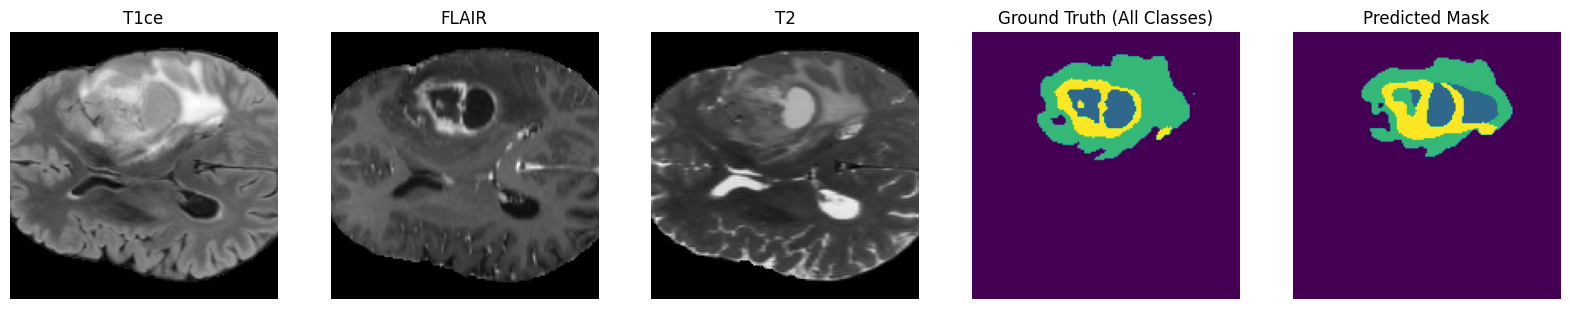

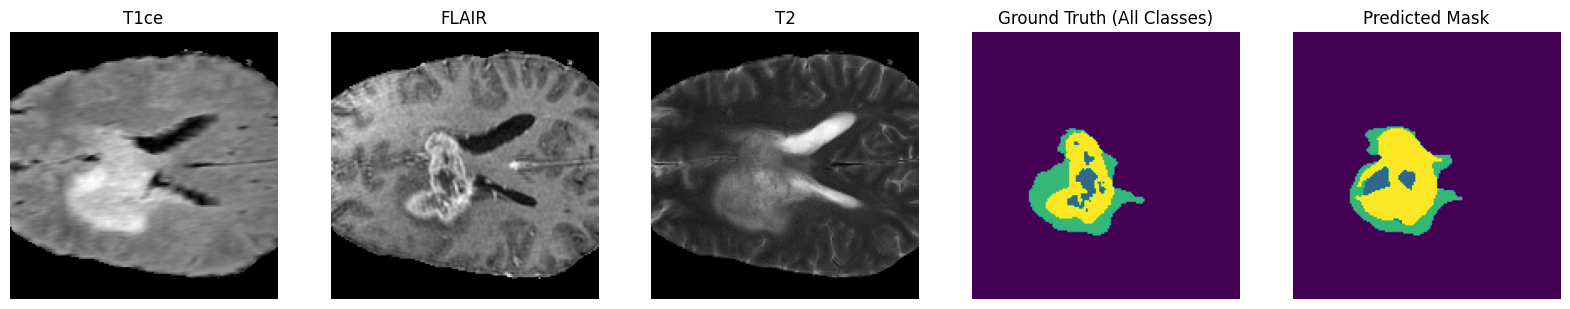

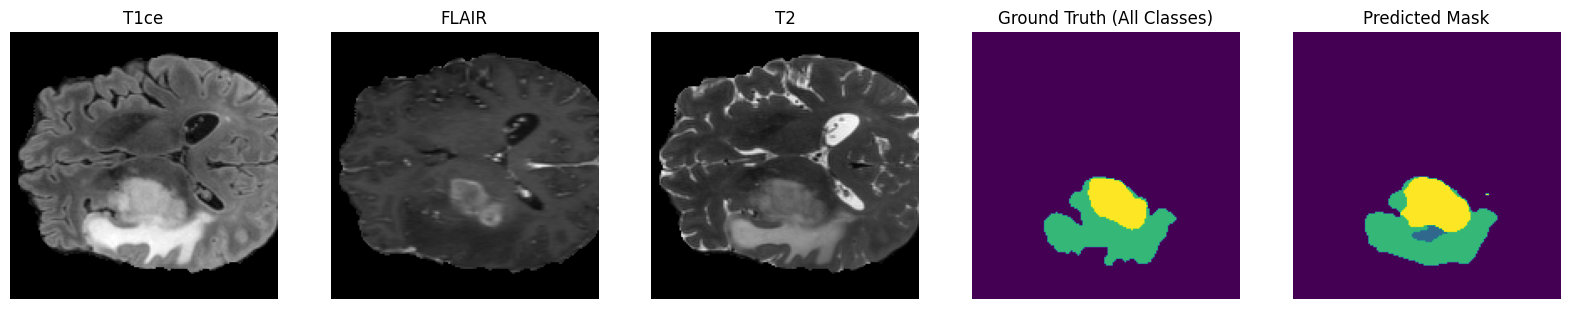

In [19]:
@torch.inference_mode()
def inference(model, loader, device="cpu", num_batches_to_process=8):
    for idx, (batch_img, batch_mask) in enumerate(loader):
        # Move batch images to the device (CPU or GPU)
        batch_img = batch_img.to(device).float()
        
        # Get the predictions from the model
        pred_all = model(batch_img)
        
        # Move the predictions to CPU and apply argmax to get predicted classes
        pred_all = pred_all.cpu().argmax(dim=1).numpy()
        
        # Optionally break after processing a fixed number of batches
        if idx == num_batches_to_process:
            break

        # Visualize images and predictions
        for i in range(0, len(batch_img)):
            fig, ax = plt.subplots(1, 5, figsize=(20, 8))
            
            middle_slice = batch_img.shape[2] // 2  # Along Depth
            
            # Visualize different modalities (e.g., T1ce, FLAIR, T2)
            ax[0].imshow(batch_img[i, 0, middle_slice, :, :].cpu().numpy(), cmap='gray')
            ax[1].imshow(batch_img[i, 1, middle_slice, :, :].cpu().numpy(), cmap='gray')
            ax[2].imshow(batch_img[i, 2, middle_slice, :, :].cpu().numpy(), cmap='gray')

            # Get the ground truth mask as class indices using argmax (combine all classes)
            gt_combined = batch_mask[i, :, middle_slice, :, :].argmax(dim=0).cpu().numpy()

            # Visualize the ground truth mask
            ax[3].imshow(gt_combined, cmap='viridis')
            ax[3].set_title('Ground Truth (All Classes)')

            # Visualize the predicted mask
            ax[4].imshow(pred_all[i, middle_slice, :, :], cmap='viridis')
            ax[4].set_title('Predicted Mask')
            
            # Set titles for the image subplot
            ax[0].set_title('T1ce')
            ax[1].set_title('FLAIR')
            ax[2].set_title('T2')
            
            # Turn off axis for all subplots
            for a in ax:
                a.axis('off')
            
            # Show the plot
            plt.show()

# Run inference
inference(model, val_loader, device="cuda", num_batches_to_process=12)


GPU:0
process      84372 uses    16180.000 MB GPU memory
